In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from joblib import dump
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix, f1_score, make_scorer)
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (LabelEncoder, MinMaxScaler, Normalizer,
                                   OneHotEncoder, PowerTransformer,
                                   RobustScaler, StandardScaler)
from xgboost import XGBClassifier

from utils.GPU_models import (KerasClassifierModel, gpu_model_hub,
                              multi_input_embedded_model)
from utils.preprocessing_utils import (clean_labs, clean_notas,
                                       clean_sociodemograficos, merge_classes,
                                       merge_labs_notas,
                                       word_count_feat_engineering)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
set_config(display="diagram")
sns.set_style("darkgrid")
as_dual_class=False
target_feature = 'Código'
text_feature = 'Plan'
consolidate_classes = True

## Data setup

In [3]:
df_notas = pd.read_csv('../data/notas.csv', sep=';')
df_laboratorios = pd.read_csv('../data/laboratorios.csv', sep=';')
df_sociodemografico = pd.read_csv('../data/sociodemografico.csv', sep=';')

In [4]:
df_notas.head()

,IDRecord,Código,Nombre,Tipo,Plan
0,44600,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,- ORDENO TAR ABC +3TC +ATV/r - PROFILAXIS NO ...
1,45038,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,- TAF/FTC/EVG/C MIPRES POR 2 MESES 20200602158...
2,40391,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,usuaria la cual se ve pertinente seguimiento d...
3,106350,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,1. Se formula TAR (TDF/FTC+EFV) 2. S/S Paracl...
4,105840,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,EDUCACIÓN Se brinda retroalimentación con rel...


In [5]:
df_laboratorios.head()

,IDRecord,Codigo,Nombre,Fecha,Valor
0,95627,902045,TIEMPO DE PROTROMBINA (PT),22/02/2022 18:43,NaN
1,125572,902045,TIEMPO DE PROTROMBINA (PT),17/02/2022 13:41,NaN
2,55788,902045,TIEMPO DE PROTROMBINA (PT),22/06/2021 12:50,1.05
3,113766,902045,TIEMPO DE PROTROMBINA (PT),5/08/2021 12:11,NaN
4,44596,902045,TIEMPO DE PROTROMBINA (PT),5/08/2021 13:15,NaN


In [6]:
df_sociodemografico.head()

,IDRecord,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,NaN
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,NaN
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+
3,307,88,Hombre,Ninguno de los anteriores,Zona Urbana,No reportado,NaN
4,325,94,Hombre,Ninguno de los anteriores,Zona Rural,Viudo/a,NaN


In [7]:
df_notas.head()

,IDRecord,Código,Nombre,Tipo,Plan
0,44600,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,- ORDENO TAR ABC +3TC +ATV/r - PROFILAXIS NO ...
1,45038,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,- TAF/FTC/EVG/C MIPRES POR 2 MESES 20200602158...
2,40391,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,usuaria la cual se ve pertinente seguimiento d...
3,106350,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,1. Se formula TAR (TDF/FTC+EFV) 2. S/S Paracl...
4,105840,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,EDUCACIÓN Se brinda retroalimentación con rel...


## Data Cleaning

In [8]:
df_sociodemografico = clean_sociodemograficos(df_sociodemografico)
df_laboratorios = clean_labs(df_laboratorios)
df_notas = clean_notas(df_notas)

### Merge the sociodemographic data with the medical notes dataset

In [9]:
df_merge = df_sociodemografico.merge(df_notas, how='inner', on='IDRecord')
df_merge

,IDRecord,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre,Código,Nombre,Tipo,Plan
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,NaN,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,PACIENTE CONTINUA PROGRAMA NEFROPROTECCION S...
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,NaN,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,CONTINUA PROGRAMA CRONICOS.
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,1- CONTINUAR PAD 2 - RECOMENDACIONES DIETA HIP...
3,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,1- CONTINUAR PAD 2 - RECOMENDACIONES DIETA HIP...
4,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Nuevo,1- CONTINUAR PAD 2 - RECOMENDACIONES DIETA HIP...
...,...,...,...,...,...,...,...,...,...,...,...
140167,205218,28,Hombre,Ninguno de los anteriores,Zona Urbana,NaN,NaN,A539,"SIFILIS, NO ESPECIFICADA",Confirmado Repetido,"explica acerca programa, recomienda adherencia..."
140168,205227,24,Hombre,Ninguno de los anteriores,Zona Urbana,Soltero,O+,A530,"SIFILIS LATENTE, NO ESPECIFICADA COMO PRECOZ O...",Confirmado Repetido,Elaboracion duelo frente diagnostico. Reforz...
140169,205253,84,Hombre,Mestizo,Zona Urbana,Casado,NaN,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,FUROATO MOMETASONA 1 SPRY NASAL CADA FOSA NASA...
140170,205577,62,Hombre,Mestizo,Zona Urbana,Desconocido,NaN,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Impresión Diagnóstica,CONTROL MEICO MES-INFECTOLOGIA VALORACIOJN IN...


## Feature Engineering

In [10]:
# Merge the classes
if consolidate_classes:
    df_merge = merge_classes(df_merge)

# Perform word count feature engineering
df_merge = word_count_feat_engineering(df_merge)

# Preprocess the lab data and merge it with the sociodemographic data
df_merge = merge_labs_notas(df_laboratorios, df_merge)

with pd.option_context('display.max_columns', None):
    display(df_merge.head(5))

,IDRecord,Edad,Genero,GrupoEtnico,AreaResidencial,EstadoCivil,TSangre,Código,Nombre,Tipo,Plan,acido,antibio,asintoma,cabeza,diabet,diet,gluco,hepat,insulin,keto,penici,preservativo,rpr,sable,serolo,sifili,test_reloj_orden,vih,top_lab_name,top_lab_avg_value,top_lab_count,total_lab_count
0,5,39,Mujer,Mestizo,Zona Urbana,Separado,NaN,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,PACIENTE CONTINUA PROGRAMA NEFROPROTECCION S...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CALCIO POR COLORIMETRÍA,8.0,1.0,8.0
1,292,84,Hombre,Ninguno de los anteriores,Zona Urbana,Casado,NaN,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,CONTINUA PROGRAMA CRONICOS.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Repetido,1- CONTINUAR PAD 2 - RECOMENDACIONES DIETA HIP...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN
3,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E109,DIABETES MELLITUSINSULINODEPENDIENTE SIN MENCI...,Confirmado Repetido,1- CONTINUAR PAD 2 - RECOMENDACIONES DIETA HIP...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN
4,300,88,Hombre,Mestizo,Zona Urbana,Soltero,O+,E119,DIABETES MELLITUS NOINSULINODEPENDIENTE SIN ME...,Confirmado Nuevo,1- CONTINUAR PAD 2 - RECOMENDACIONES DIETA HIP...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN


## Label encoding

In [11]:
X = df_merge.drop(labels=[target_feature], axis=1)
y = df_merge[target_feature]
if as_dual_class:
    y = y.str[:2]

label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(y)

np.unique(y_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([ 3685, 60586, 49378,  6278, 17437,  2808]))

## Train-test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y_labels, train_size=0.2, random_state=42, stratify=y_labels)

## Hyperparameter Setup

In [13]:
numerical_features = list(set(['Edad', 'top_lab_avg_value', 'top_lab_count', 'total_lab_count'] + list(df_merge.drop(columns='IDRecord').select_dtypes(include='int64').columns)))
categorical_features = ['Genero', 'GrupoEtnico', 'AreaResidencial', 'EstadoCivil', 'TSangre', 'Tipo', 'top_lab_name']

In [14]:
base_estimator = XGBClassifier()

numeric_preprocessor = Pipeline(
    steps=[
        (
            "imputer",
            SimpleImputer(missing_values=np.nan, strategy="mean"),
        ),
        ("scaler", StandardScaler()),
    ]
)

categorical_preprocessor = Pipeline(
    steps=[
        (
            "imputer",
            SimpleImputer(fill_value="missing", strategy="constant"),
        ),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

text_preprocessor = Pipeline(
    steps=[
        (
            "vectorizer",
            CountVectorizer(
                strip_accents="unicode",
                stop_words=nltk.corpus.stopwords.words("spanish"),
            ),
        ),
        ("tfidf", TfidfTransformer()),
    ]
)

preprocessor = ColumnTransformer(
    [
        ("categorical", categorical_preprocessor, categorical_features),
        ("numerical", numeric_preprocessor, numerical_features),
        # ("text", text_preprocessor, text_features),
    ]
)

pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("estimator", base_estimator),
    ]
)

## Hyperparameter tuning

In [15]:
param_grid = {
    "preprocessor__numerical__imputer": [
        SimpleImputer(missing_values=np.nan, strategy="mean"),
        SimpleImputer(missing_values=np.nan, strategy="median"),
        SimpleImputer(missing_values=np.nan, strategy="most_frequent"),
        KNNImputer(),
    ],
    "preprocessor__numerical__scaler": [
        StandardScaler(),
        RobustScaler(),
        MinMaxScaler(),
        Normalizer(),
        # PowerTransformer(),
    ],
}

In [16]:
scoring = {
    "Accuracy": "balanced_accuracy",
    "Weighted_F1": make_scorer(f1_score, average='weighted'),
    # 'roc_auc':make_scorer(roc_auc_score, average='weighted'),
    }

hyperparam_tuner = RandomizedSearchCV(
    pipeline,
    param_grid,
    n_iter=8,
    cv=3,
    n_jobs=-2,
    scoring=scoring,
    refit='Weighted_F1',
    verbose = 2,
    random_state=42,
)

hyperparam_tuner.fit(X_train, y_train)
cv_results = pd.DataFrame(hyperparam_tuner.cv_results_)

best_estimator = hyperparam_tuner.best_estimator_
preprocessor = best_estimator.named_steps['preprocessor']
preprocessor

Fitting 3 folds for each of 8 candidates, totalling 24 fits


ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Genero', 'GrupoEtnico', 'AreaResidencial',
                                  'EstadoCivil', 'TSangre', 'Tipo',
                                  'top_lab_name']),
                                ('numerical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', RobustScaler())]),
                                 ['serolo', 'acido', 'diabet', 'keto', 'gluco',
                                  'insulin', 'vih', 'test_reloj_orden', 'hepat',
                                  'antibio', 'Edad', 'penici',
                                  'top_lab_avg_value', 'sable', 'asintoma',
                                  'sifili', 'cabeza', 'preservativo', 'rpr',
                                  'top_lab_count', 'diet',
                                  'total_lab_count'])])

In [17]:
with pd.option_context('display.max_columns', None):
    display(cv_results.sort_values(by=["rank_test_Weighted_F1"]).head(30))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__numerical__scaler,param_preprocessor__numerical__imputer,params,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,split0_test_Weighted_F1,split1_test_Weighted_F1,split2_test_Weighted_F1,mean_test_Weighted_F1,std_test_Weighted_F1,rank_test_Weighted_F1
2,28.766019,5.315409,1.316131,0.369004,RobustScaler(),SimpleImputer(strategy='median'),{'preprocessor__numerical__scaler': RobustScal...,0.711343,0.699356,0.705687,0.705462,0.004896,1,0.790669,0.794670,0.790954,0.792098,0.001823,1
0,39.986937,0.423906,0.824331,0.108934,StandardScaler(),SimpleImputer(),{'preprocessor__numerical__scaler': StandardSc...,0.692354,0.696689,0.690167,0.693070,0.002710,3,0.784238,0.789409,0.783753,0.785800,0.002559,2
7,23.454593,1.416722,0.638453,0.110169,RobustScaler(),SimpleImputer(strategy='most_frequent'),{'preprocessor__numerical__scaler': RobustScal...,0.694840,0.694938,0.694527,0.694768,0.000175,2,0.780292,0.779474,0.786478,0.782081,0.003127,3
1,22.782638,0.784244,1.065082,0.169143,RobustScaler(),SimpleImputer(),{'preprocessor__numerical__scaler': RobustScal...,0.686236,0.684279,0.698842,0.689786,0.006454,6,0.776238,0.781896,0.783331,0.780488,0.003062,4
6,31.624396,1.625617,0.582648,0.148619,StandardScaler(),SimpleImputer(strategy='most_frequent'),{'preprocessor__numerical__scaler': StandardSc...,0.690552,0.686627,0.677605,0.684928,0.005421,7,0.779873,0.783686,0.775889,0.779816,0.003184,5
3,130.318106,4.405675,31.727025,1.818723,MinMaxScaler(),KNNImputer(),{'preprocessor__numerical__scaler': MinMaxScal...,0.686715,0.691338,0.693255,0.690436,0.002745,4,0.770859,0.783676,0.780620,0.778385,0.005466,6
4,125.172069,6.936556,30.413966,2.566695,RobustScaler(),KNNImputer(),{'preprocessor__numerical__scaler': RobustScal...,0.682485,0.688547,0.699971,0.690334,0.007250,5,0.777445,0.778286,0.774313,0.776681,0.001709,7
5,56.880764,9.205209,0.920793,0.331265,Normalizer(),SimpleImputer(strategy='most_frequent'),{'preprocessor__numerical__scaler': Normalizer...,0.673542,0.646597,0.648995,0.656378,0.012176,8,0.767745,0.760702,0.773733,0.767393,0.005326,8


In [18]:
X_train_preprocessed = pd.DataFrame.sparse.from_spmatrix(preprocessor.transform(X_train), columns=list(preprocessor.get_feature_names_out()))
X_test_preprocessed = pd.DataFrame.sparse.from_spmatrix(preprocessor.transform(X_test), columns=list(preprocessor.get_feature_names_out()))

In [19]:
# embedding = "nnlm-es-dim128"
embedding = "nnlm-es-dim128-with-normalization"
# embedding = "https://tfhub.dev/jeongukjae/xlm_roberta_multi_cased_L-24_H-1024_A-16/1"


model_function = multi_input_embedded_model
clf = KerasClassifierModel(
    build_fn=model_function,
    class_number=len(np.unique(y_train)),
    feature_number=len(X_train_preprocessed.columns),
    embedding = embedding,
    activation='relu',
    epochs=500,
    batch_size=200,
    verbose=10,
)

hist = clf.fit([X_train_preprocessed, X_train[text_feature]], y_train)
clf.plot_learning_curves('data/output/gpu_model')

ValueError: Input 0 of layer "spatial_dropout1d" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 128)

## Scoring

In [ ]:
labels_decoded = label_encoder.inverse_transform(np.unique(y_train))
y_pred = clf.predict([X_test_preprocessed, X_test[text_feature]])

3505/3505 [==============================] - 62s 17ms/step


In [ ]:
display(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True, labels=np.unique(y_train), target_names=labels_decoded, zero_division=False)).transpose().round(2))

,precision,recall,f1-score,support
A510,0.00,0.00,0.00,782.00
A511,0.00,0.00,0.00,75.00
A514,0.00,0.00,0.00,2091.00
A529,0.50,0.01,0.02,1576.00
A530,0.63,0.87,0.73,48469.00
A539,0.76,0.55,0.64,37927.00
E109,0.64,0.26,0.37,5022.00
E119,0.63,0.70,0.67,13950.00
E149,0.00,0.00,0.00,2246.00
accuracy,0.66,0.66,0.66,0.66


<Figure size 640x480 with 0 Axes>

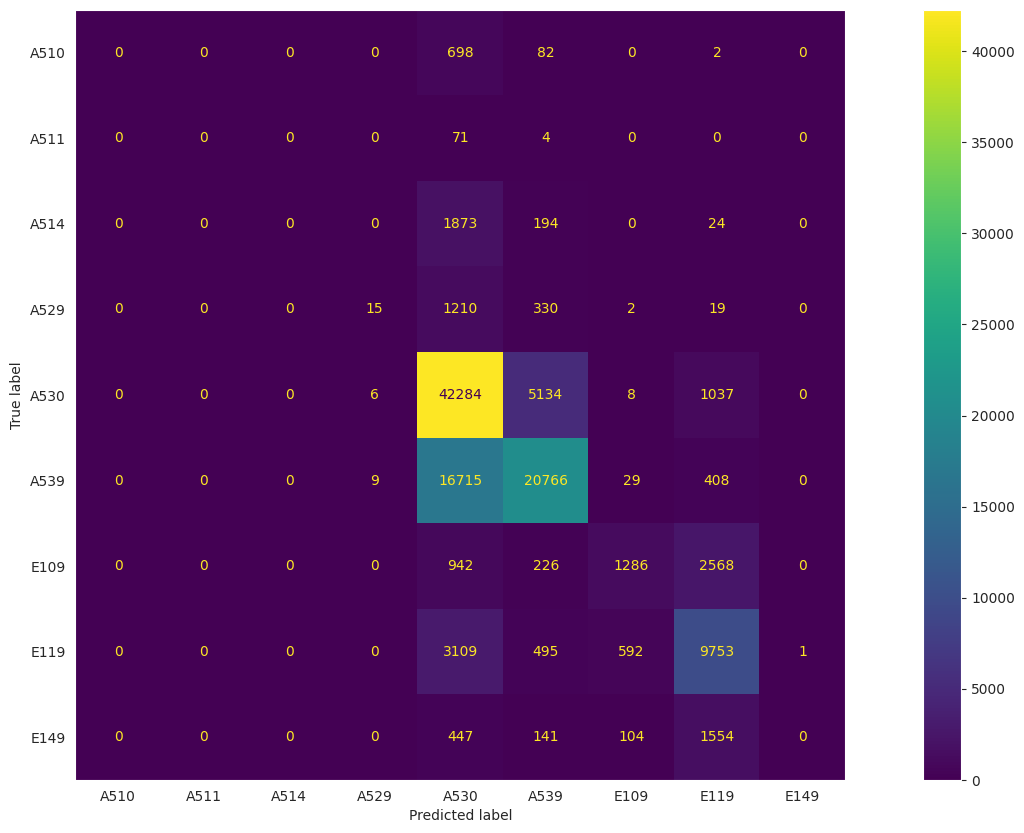

In [ ]:
test_confusion_matrix = confusion_matrix(y_test, y_pred)

with sns.axes_style("dark"):
    fig, ax = plt.subplots(figsize=(20,10))
    disp = ConfusionMatrixDisplay(confusion_matrix=test_confusion_matrix,
                                display_labels=labels_decoded)
    disp.plot(ax=ax, cmap='viridis')
    plt.show()

## Saving the best performing model

In [ ]:
save_path = Path('data') / 'output' / 'best_model.pickle'
save_path.parent.mkdir(parents=True, exist_ok=True)
dump(best_model, str(save_path))
dump(score, str(save_path.parent / f'best_model_score{save_path.suffix}'))

NameError: name 'best_model' is not defined